In [2]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import pyntcloud
from pyntcloud import PyntCloud
print("Environment Ready")

# %matplotlib
%load_ext autoreload
%autoreload 2

Environment Ready


In [3]:
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file("data/shadow_with_objects.bag")
profile = pipe.start(cfg)

# Skip 5 first frames to give the Auto-Exposure time to adjust
for x in range(120):
  pipe.wait_for_frames()
  
# Store next frameset for later processing:
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

# Cleanup:
pipe.stop()
print("Frames Captured")

Frames Captured


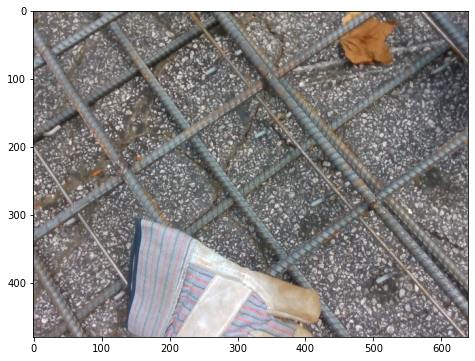

In [4]:
color = np.asanyarray(color_frame.get_data())
plt.rcParams["axes.grid"] = False
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(color)

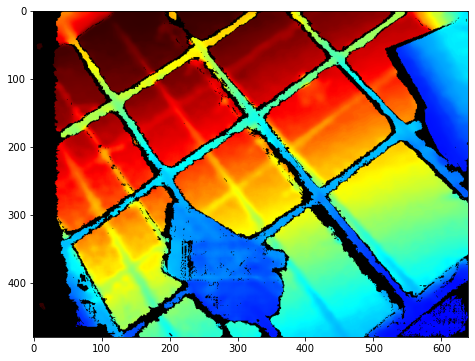

In [5]:
colorizer = rs.colorizer()
colorized_depth = np.asanyarray(colorizer.colorize(depth_frame).get_data())
plt.imshow(colorized_depth)

In [6]:
# align = rs.align(rs.stream.color)
# frameset = align.process(frameset)

# # Update color and depth frames:
# aligned_depth_frame = frameset.get_depth_frame()
# colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# colorized_depth_cp = np.zeros_like(colorized_depth).astype(np.int)

# colorized_depth_cp[colorized_depth[:,:,2]>100,:]=255
# colorized_depth_cp[(colorized_depth[:,:,1]>200) & (colorized_depth[:,:,1]<300),:]=0


# # Show the two frames together:
# images = np.hstack((color, colorized_depth_cp))
# plt.imshow(images)
# # plt.imshow(colorized_depth_cp)

# depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
# print(depth_scale)

# depth = np.asanyarray(aligned_depth_frame.get_data())
# # Crop depth data:

# colorized_depth_meters = depth_scale * np.mean(colorized_depth, axis=2)
# print("Depth in meters : ", colorized_depth_meters)


In [7]:
# mean_depth = depth_scale * np.mean(colorized_depth, axis=2)
# plt.imshow(mean_depth)

In [8]:
# pc = rs.pointcloud();
# pc.map_to(color_frame);
# pointcloud = pc.calculate(depth_frame);
# pointcloud.export_to_ply("2.ply", color_frame);
# cloud = PyntCloud.from_file("2.ply");
# cloud.plot()

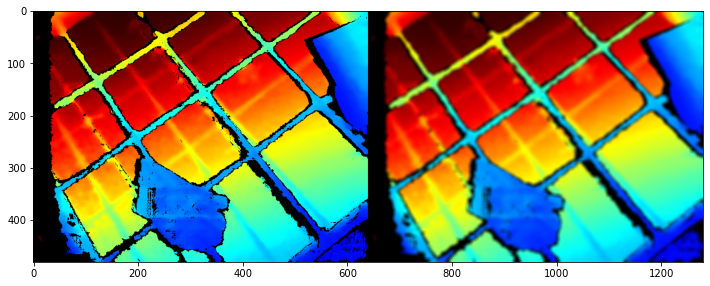

In [9]:
depth_blue = colorized_depth[:,:,:]/255.1
depth_blur = cv2.GaussianBlur(depth_blue,(9,9),cv2.BORDER_DEFAULT)
images = np.hstack((depth_blue,depth_blur))
plt.imshow(images)


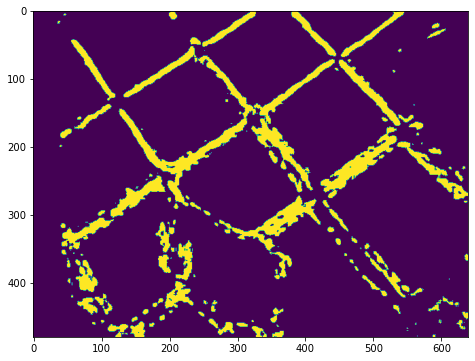

In [18]:
depth_laplacian = cv2.Laplacian(depth_blur,cv2.CV_64F)
depth_laplacian = (depth_laplacian - depth_laplacian.min())
depth_laplacian = depth_laplacian/depth_laplacian.max()
depth_laplacian_cp = np.ones_like(depth_laplacian)
depth_laplacian_cp[(depth_laplacian>0.4)&(depth_laplacian<0.6)]=0
gray = np.mean(depth_laplacian_cp,axis=2)
gray = cv2.GaussianBlur(gray,(9,9),cv2.BORDER_DEFAULT)
gray = gray/gray.max()
th = 0.3
gray[gray>th]=1
gray[gray<th]=0
plt.imshow(gray)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# H,W,_ = depth_laplacian.shape
# x = range(W)
# y = range(H)
# X, Y = np.meshgrid(x, y)
# ax.plot_surface(X,Y,gray)


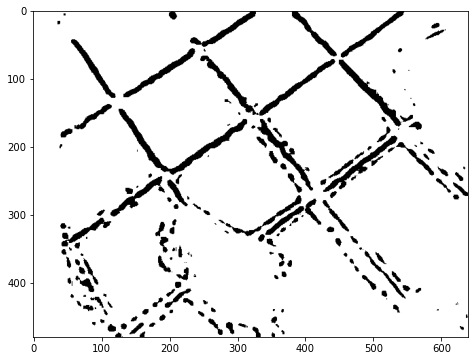

In [11]:

gray = gray.astype(np.float32)

plt.imshow(gray,cmap=plt.cm.binary)


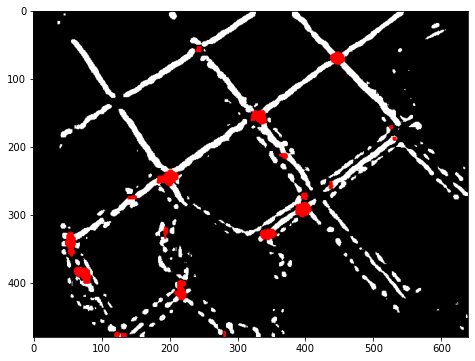

In [12]:
# gray = np.mean(depth_laplacian_cp,axis=2)

dst = cv2.cornerHarris(gray,31,7,0.0004)
dst = cv2.dilate(dst,None)
gray3 = np.dstack((gray,gray,gray))
gray3[dst>(0.6*dst.max())]=np.array([1,0,0])
plt.imshow(gray3)

(480, 640)


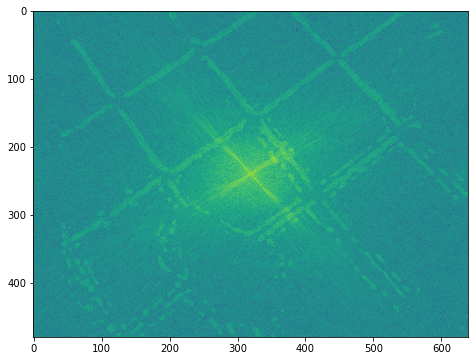

In [17]:
print(gray.shape)
f = np.fft.fft2(gray)
# f = np.fft.fft2(np.mean(depth_blur,axis=2))

fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.imshow(magnitude_spectrum/magnitude_spectrum.max() + gray/10)